# Exercise 3

In this exercise, I will analyze the tamplates and I will add some other templates. 

uint8


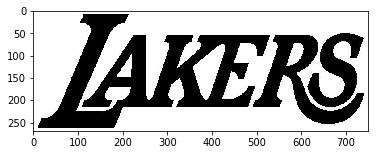

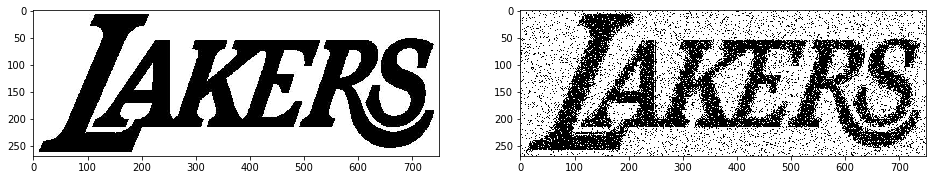

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imtool
from scipy.signal import convolve2d as conv2d

imorg = imtool.imread('dd.jpg') # load image file
plt.imshow(imorg, cmap='gray')                             # show binary image in gray scale
print(imorg.dtype.name)
imorg = imorg.astype(np.float32) #transfer image into float32

def addnoise(imorg, nratio=0.1):
    imnsy = imorg.copy()
    # convert '0' to '-1'
    imnsy[imnsy == 0] = -1
    imnsy[imnsy > 0] = 1
    # create random value to indicate flipping pixels
    index = np.random.rand(*imnsy.shape)
    # flip pixels to generate noisy image
    imnsy[index < nratio] *= -1
    
    return imnsy

imnsy = addnoise(imorg, nratio = 0.1)

def showimgs(*args, ncol=2):
    if not args:
        return
    # initialize figure with specific size
    plt.figure(figsize=(16, 10))
    # compose subplot index
    nrow = np.ceil(len(args) / ncol)
    subindex = nrow * 100 + ncol * 10
    # draw each image in subplot
    for i, img in enumerate(args):
        plt.subplot(subindex + i + 1)
        plt.imshow(img, cmap='gray')

showimgs(imorg, imnsy)

In [2]:
def denoise(imnsy, efunc, showproc = False):
    # initialize recoverred image as noisy image
    imrec = imnsy.copy()
    # show noisy image
    if showproc:
        plt.imshow(imrec, cmap='gray')
        plt.title('Noisy Image')
        plt.show()
    # calculate energy function and its gradients
    E, dE = efunc(imrec, imnsy)
    # initialize temporal energy and iteration count
    Etmp, i = E + 1, 0
    # optimize energy function through iteration
    while Etmp > E:
        Etmp = E
        # update image by flipping all pixels, which could decrease energy function
        imrec[dE < 0] *= -1
        # calculate energy function with revised image
        [E, dE] = efunc(imrec, imnsy)
        # update iteration count
        i += 1
        # show revised image
        if showproc:
            plt.imshow(imrec, cmap='gray')
            plt.title('Recovered Image (Iter-%d)' % i)
            plt.show()
    # map '-1' to 0 in recovered image
    imrec[imrec == -1] = 0
    # return recovered image
    return imrec

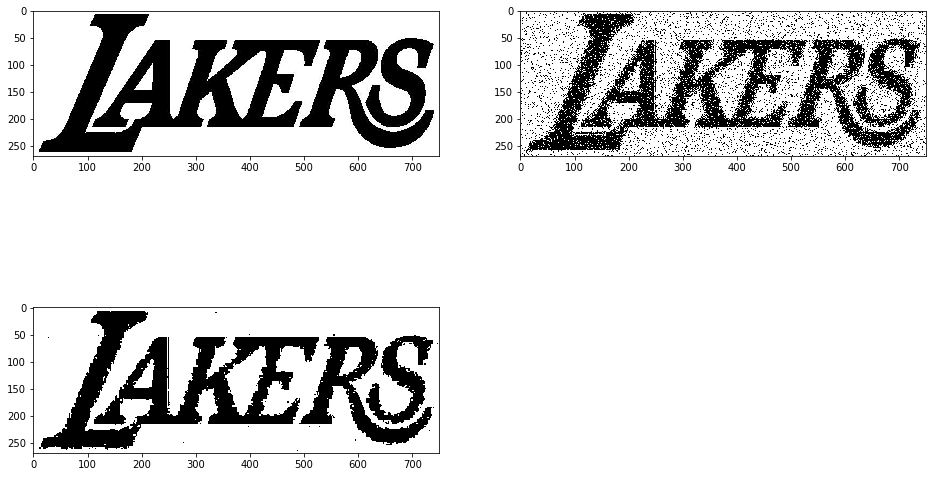

In [3]:
def defaultEnergyFunction(hidden, observation, alpha = 1, beta = 1, eta = 1):
    # create filter for beta term
    Tb = np.asarray([[0, 1.0, 0], [1.0, 0, 1.0], [0, 1.0, 0]])
    # convolve hidden image with term B's filter
    matB = conv2d(hidden, Tb, 'same')
    # calculate energy map
    mapE = hidden * (alpha - beta * matB - eta * observation)
    # get mean of matrix as energy
    E = np.mean(mapE)
    # calculate energy difference map
    dE = -2 * mapE
    
    return E, dE

medFilter = lambda hidden, observation: defaultEnergyFunction(hidden, observation,
                                                              alpha=0, beta=1, eta=0)

imrecMed = denoise(imnsy, medFilter)
showimgs(imorg, imnsy,imrecMed)

In the extension, TA gave us many tamplates. I will analyze them. 

<img src="imgdenoise/template-gamma.png" width="300">

With testing, I found that this plate can make image smooth. But I don't think this plate can help lot in denoising so I decided to change into another plate:  
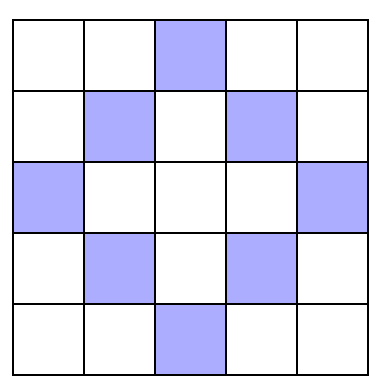  
  
According to the MRF, we know that the $x_i$ will be influenced by the neighbor points around the point, so considering what points we need is important, the distance between neighbor points and $x_i$ cannot be two far, if we choose the neighbor points which are too far from $x_i$, the effect of noise points will be heavy. So we need to find an appropriate.   

I will use this plate with $T_{\beta}$ together.This conbination means that the points which may influence the center point are the points which has 1 to 2 distance to the center point. I think 1 to 2 distance is an appropriate distance.  


In [4]:
def extendEnergyFunction(hidden, observation, 
                         alpha=1, c=1,beta=1, gamma=1, phi=1, sigma=1, eta=1):
    # template alpha
    Ta = np.asarray([[[-1,-1,-1,-1,1],[-1,-1,-1,1,-1],[-1,-1,0,-1,-1],[-1,1,-1,-1,-1],[1,-1,-1,-1,-1]],
                     [[-1,-1,1,-1,-1],[-1,-1,1,-1,-1],[-1,-1,0,-1,-1],[-1,-1,1,-1,-1],[-1,-1,1,-1,-1]],
                     [[1,-1,-1,-1,-1],[-1,1,-1,-1,-1],[-1,-1,0,-1,-1],[-1,-1,-1,1,-1],[-1,-1,-1,-1,1]],
                     [[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1],[1,1,0,1,1],[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1]]])
    # template beta
    Tb = np.asarray([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
    # template gamma
    Tr = np.asarray([[1,1,1,1,1],[1,0,0,0,1],[1,0,0,0,1],[1,0,0,0,1],[1,1,1,1,1]])
    # template phi
    Tp = np.asarray([[0,0,1,0,0],[0,0,1,0,0],[1,1,0,1,1],[0,0,1,0,0],[0,0,1,0,0]])
    # template sigma
    Ts = np.asarray([[[1,-1,-1,-1,-1],[1,0,-1,-1,-1],[1,1,0,-1,-1],[1,1,1,0,-1],[1,1,1,1,1]],
                     [[1,1,1,-1,-1],[1,1,0,-1,-1],[1,1,0,-1,-1],[1,1,0,-1,-1],[1,1,1,-1,-1]],
                     [[1,1,1,1,1],[1,1,1,0,-1],[1,1,0,-1,-1],[1,0,-1,-1,-1],[1,-1,-1,-1,-1]],
                     [[1,1,1,1,1],[1,1,1,1,1],[1,0,0,0,1],[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1]],
                     [[1,1,1,1,1],[-1,0,1,1,1],[-1,-1,0,1,1],[-1,-1,-1,0,1],[-1,-1,-1,-1,1]],
                     [[-1,-1,1,1,1],[-1,-1,0,1,1],[-1,-1,0,1,1],[-1,-1,0,1,1],[-1,-1,1,1,1]],
                     [[-1,-1,-1,-1,1],[-1,-1,-1,0,1],[-1,-1,0,1,1],[-1,0,1,1,1],[1,1,1,1,1]],
                     [[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1],[1,0,0,0,1],[1,1,1,1,1],[1,1,1,1,1]]])
    
    Tc= np.asarray([[0,0,1,0,0],[0,1,0,1,0],[1,0,0,0,1],[0,1,0,1,0],[0,0,1,0,0]])
    
    # generate parameter matrix alpha
    matA = np.empty(hidden.shape)
    for T in Ta:
        matA = np.maximum(matA, hidden * conv2d(hidden, T, 'same'))
    # generate parameter matrix beta
    matB = conv2d(hidden, Tb, 'same')
    # generate parameter matrix gamma
    matR = conv2d(hidden, Tr, 'same')
    # generate parameter matrix phi
    matP = conv2d(hidden, Tp, 'same')
    
    matc = conv2d(hidden, Tc, 'same')
    # generate parameter matrix sigma
    matS = np.empty(hidden.shape)
    for T in Ts:
        matS = np.maximum(matS, hidden * conv2d(hidden, T, 'same'))
        
    # calculate energy map
    mapE = -alpha*matA - sigma*matS - hidden*(c*matc+beta*matB + gamma*matR + phi*matP + eta*observation)
    # get energy value as mean of map
    E = np.mean(mapE)
    # calculate energy difference map
    dE = -2 * mapE
    
    return E, dE

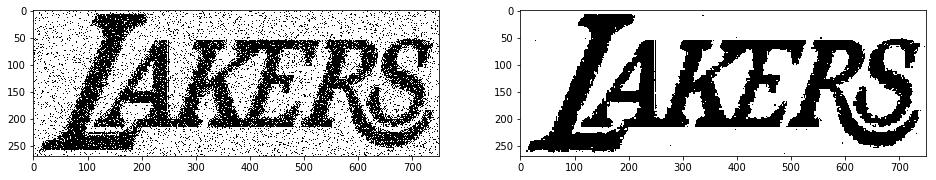

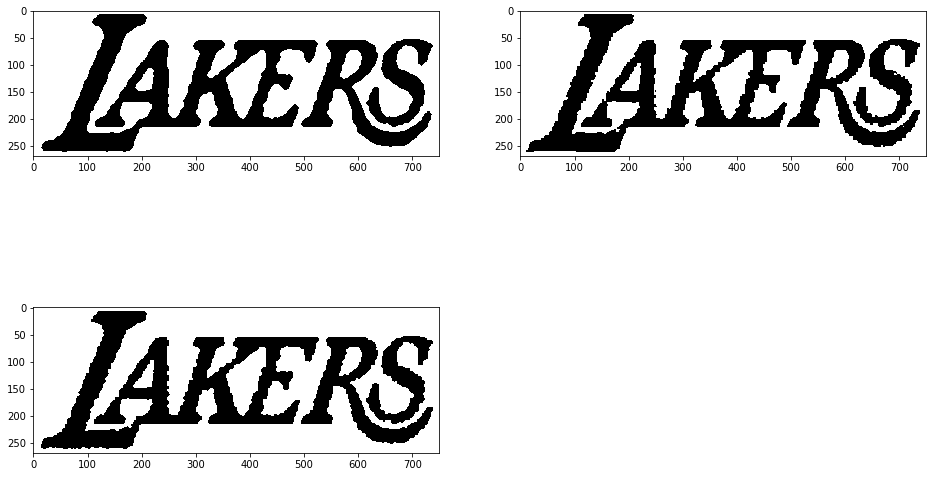

In [5]:
med1 = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                alpha=0, c=0,beta=1, gamma=0.1, 
                                                                phi=0, sigma=0, eta=0)

med2 = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                  alpha=0, c=0,beta=0, gamma=0, 
                                                                  phi=1, sigma=0, eta=0)

med3 = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                  alpha=0, c=1,beta=1, gamma=0, 
                                                                  phi=0, sigma=0, eta=0)
# denoise image with new energy functions
imrecMed1 = denoise(imnsy, med1)
imrecMed2 = denoise(imnsy, med2)
imrecMed3 = denoise(imnsy, med3)

# compare result from different median filter
showimgs(imnsy, imrecMed) 
showimgs(imrecMed1,imrecMed2,imrecMed3) 

According to the results, we find that if we use $T_{\gamma}$ and $T_{\beta}$, the image will become more smooth.  
As the notebook said, the if we use $T_{\phi}$ alone, the result will be better than using the $T_{\gamma}$ and $T_{\beta}$.  
My combination show a good result, I think it is not worse than using $T_{\phi}$ alone.  
So it the distance from 1 to 2 is an appropriate distance.

<img src="imgdenoise/template-alpha.png" width="300">
<img src="imgdenoise/template-sigma.png" width="300">

These two plates can prevent edge and corrosion and speed up optimization.  
The difference between two plates is that the former one it trying to preserving lines, while the later one for edges. 
So I increase the weight of two plate, here are comparions:

In [6]:
med4 = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                alpha=0.1, c=0,beta=0, gamma=0, 
                                                                phi=1, sigma=0, eta=0)

med5 = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                  alpha=0, c=0,beta=0, gamma=0, 
                                                                  phi=1, sigma=0.1, eta=0)
med6 = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                  alpha=0.3, c=0,beta=0, gamma=0, 
                                                                  phi=1, sigma=0, eta=0)
med7 = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                  alpha=0, c=0,beta=0, gamma=0, 
                                                                  phi=1, sigma=0.3, eta=0)
med8 = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                  alpha=0.5, c=0,beta=0, gamma=0, 
                                                                  phi=1, sigma=0, eta=0)
med9 = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                  alpha=0, c=0,beta=0, gamma=0, 
                                                                  phi=1, sigma=0.5, eta=0)
med0 = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                  alpha=0.1, c=0,beta=0, gamma=0, 
                                                                  phi=1, sigma=0.1, eta=0)
# denoise image with new energy functions
imrecMed4 = denoise(imnsy, med4)
imrecMed5 = denoise(imnsy, med5)
imrecMed6 = denoise(imnsy, med6)
imrecMed7 = denoise(imnsy, med7)
imrecMed8 = denoise(imnsy, med8)
imrecMed9 = denoise(imnsy, med9)
imrecMed0 = denoise(imnsy, med0)
# compare result from different median filter

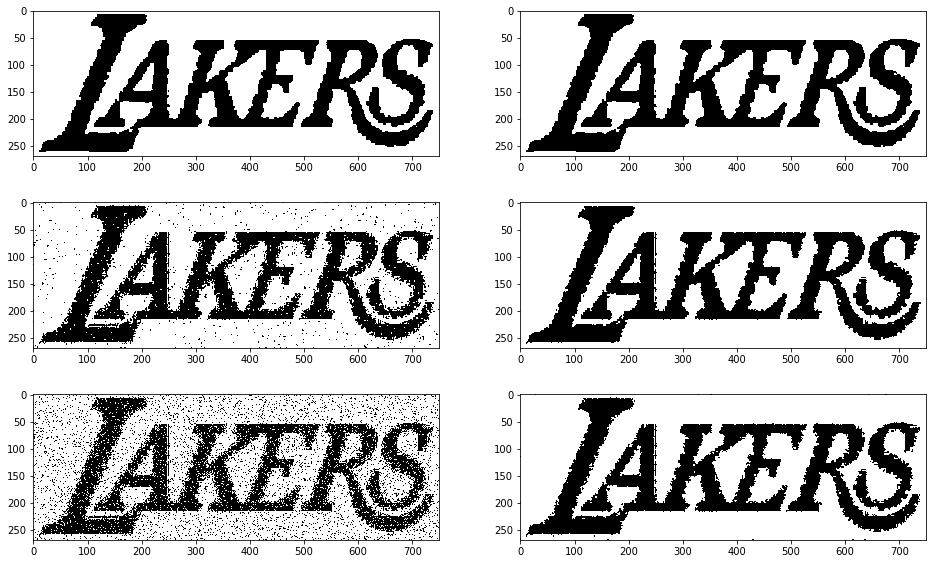

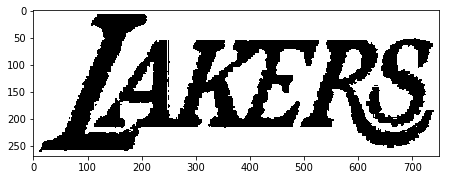

In [7]:
showimgs(imrecMed4,imrecMed5,imrecMed6,imrecMed7,imrecMed8,imrecMed9) 
showimgs(imrecMed0) 

According to these results, we can find that with increasing the weight, image after using first plate gets more and more noise points, but image using second plate always performances well. I think the reason may be that the first plate may regard some noise which in an line order as real line. So these noise points are prevented by the first plate.    

The second line will prevent the true edges so it cannot regard the noise points which in a line order as true edge.But when I increased the weight, the performance of second plate is not good,either. I think the second plate also regard some noisy points as edges.  

When I combine two plate together, the result shows bad. It is interesting.

Now, I will add these two plates into denoising.

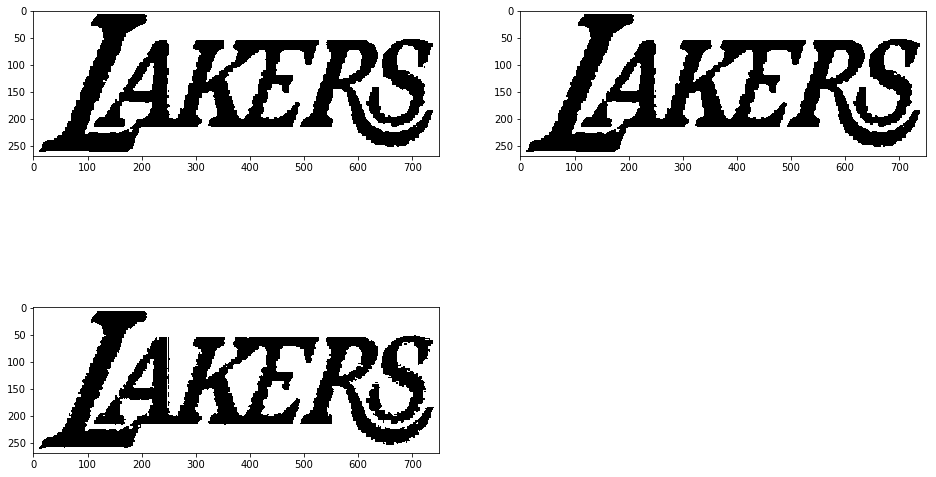

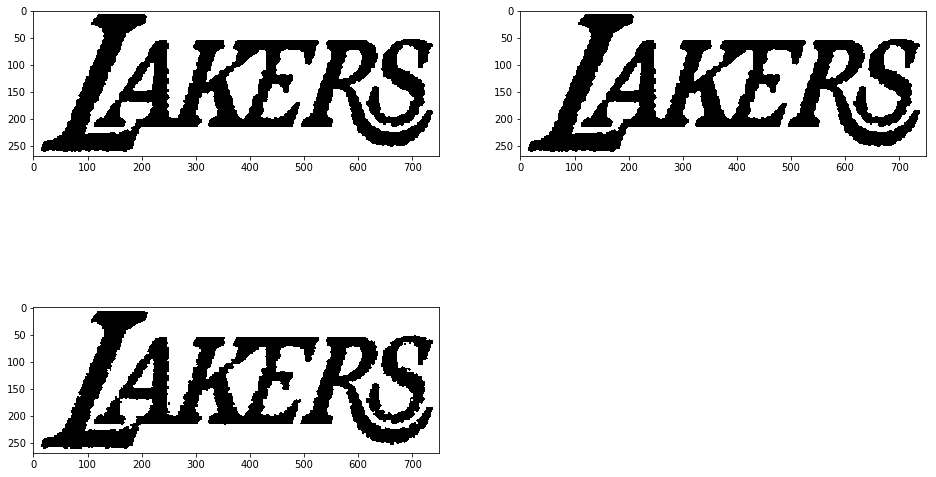

In [8]:
med21 = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                  alpha=0.1, c=0,beta=0, gamma=0, 
                                                                  phi=1, sigma=0, eta=0)
med22 = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                  alpha=0, c=0,beta=0, gamma=0, 
                                                                  phi=1, sigma=0.1, eta=0)
med23 = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                  alpha=0.1, c=0,beta=0, gamma=0, 
                                                                  phi=1, sigma=0.1, eta=0)

med31 = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                  alpha=0.1, c=1,beta=1, gamma=0, 
                                                                  phi=0, sigma=0, eta=0)
med32 = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                  alpha=0, c=1,beta=1, gamma=0, 
                                                                  phi=0, sigma=0.1, eta=0)
med33 = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                  alpha=0.1, c=1,beta=1, gamma=0, 
                                                                  phi=0, sigma=0.1, eta=0)
# denoise image with new energy functions
imrecMed21 = denoise(imnsy, med21)
imrecMed22 = denoise(imnsy, med22)
imrecMed23 = denoise(imnsy, med23)
imrecMed31 = denoise(imnsy, med31)
imrecMed32 = denoise(imnsy, med32)
imrecMed33 = denoise(imnsy, med33)
# compare result from different median filter
showimgs(imrecMed21, imrecMed22,imrecMed23) 
showimgs(imrecMed31, imrecMed32,imrecMed33) 

We can find that after using these two plates, lines and edges can be prevented.   
Compare with using phi alone and my conbination, when I use two plates separately, $T_{\alpha}$ performance little better than $T_{\gamma}$. But when I combine $T_{\alpha}$ and $T_{\gamma}$ together, the result is nor good. It is interesting.  
In my combination, results of $T_{\gamma}$ and $T_{\alpha}$ is closed. As the same, when I combine two plates together, the results is also not good. 

I have an idea, if I let the sum of the parameters in $T_{\phi}$ is 1, what will happen?  
And what if I use a 3x3 plate in a 5x5 plate? I mean:  
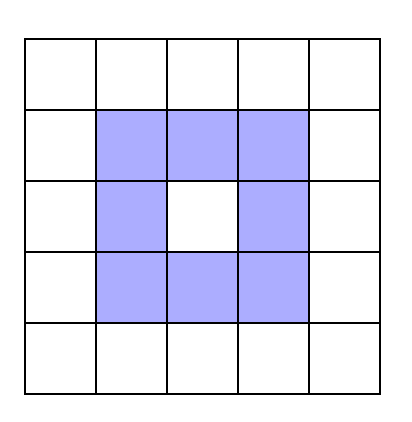

In [9]:
def extendEnergyFunction2(hidden, observation, 
                         alpha=1, c=1,d=1,e=1,beta=1, gamma=1, phi=1, sigma=1, eta=1):
    # template alpha
    Ta = np.asarray([[[-1,-1,-1,-1,1],[-1,-1,-1,1,-1],[-1,-1,0,-1,-1],[-1,1,-1,-1,-1],[1,-1,-1,-1,-1]],
                     [[-1,-1,1,-1,-1],[-1,-1,1,-1,-1],[-1,-1,0,-1,-1],[-1,-1,1,-1,-1],[-1,-1,1,-1,-1]],
                     [[1,-1,-1,-1,-1],[-1,1,-1,-1,-1],[-1,-1,0,-1,-1],[-1,-1,-1,1,-1],[-1,-1,-1,-1,1]],
                     [[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1],[1,1,0,1,1],[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1]]])
    # template beta
    Tb = np.asarray([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
    # template gamma
    Tr = np.asarray([[1,1,1,1,1],[1,0,0,0,1],[1,0,0,0,1],[1,0,0,0,1],[1,1,1,1,1]])
    # template phi
    Tp = np.asarray([[0,0,1,0,0],[0,0,1,0,0],[1,1,0,1,1],[0,0,1,0,0],[0,0,1,0,0]])
    # template sigma
    Ts = np.asarray([[[1,-1,-1,-1,-1],[1,0,-1,-1,-1],[1,1,0,-1,-1],[1,1,1,0,-1],[1,1,1,1,1]],
                     [[1,1,1,-1,-1],[1,1,0,-1,-1],[1,1,0,-1,-1],[1,1,0,-1,-1],[1,1,1,-1,-1]],
                     [[1,1,1,1,1],[1,1,1,0,-1],[1,1,0,-1,-1],[1,0,-1,-1,-1],[1,-1,-1,-1,-1]],
                     [[1,1,1,1,1],[1,1,1,1,1],[1,0,0,0,1],[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1]],
                     [[1,1,1,1,1],[-1,0,1,1,1],[-1,-1,0,1,1],[-1,-1,-1,0,1],[-1,-1,-1,-1,1]],
                     [[-1,-1,1,1,1],[-1,-1,0,1,1],[-1,-1,0,1,1],[-1,-1,0,1,1],[-1,-1,1,1,1]],
                     [[-1,-1,-1,-1,1],[-1,-1,-1,0,1],[-1,-1,0,1,1],[-1,0,1,1,1],[1,1,1,1,1]],
                     [[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1],[1,0,0,0,1],[1,1,1,1,1],[1,1,1,1,1]]])
    
    Tc= np.asarray([[0,0,1,0,0],[0,1,0,1,0],[1,0,0,0,1],[0,1,0,1,0],[0,0,1,0,0]])
    Td= np.asarray([[0,0,1/8,0,0],[0,0,1/8,0,0],[1/8,1/8,0,1/8,1/8],[0,0,1/8,0,0],[0,0,1/8,0,0]])
    Te= np.asarray([[0,1,1,1,0],[0,1,1,1,0],[0,1,0,1,0],[0,1,1,1,0],[0,1,1,1,0]])

    # generate parameter matrix alpha
    matA = np.empty(hidden.shape)
    for T in Ta:
        matA = np.maximum(matA, hidden * conv2d(hidden, T, 'same'))
    # generate parameter matrix beta
    matB = conv2d(hidden, Tb, 'same')
    # generate parameter matrix gamma
    matR = conv2d(hidden, Tr, 'same')
    # generate parameter matrix phi
    matP = conv2d(hidden, Tp, 'same')
    
    matc = conv2d(hidden, Tc, 'same')
    matd = conv2d(hidden, Td, 'same')
    mate = conv2d(hidden, Te, 'same')
    # generate parameter matrix sigma
    matS = np.empty(hidden.shape)
    for T in Ts:
        matS = np.maximum(matS, hidden * conv2d(hidden, T, 'same'))
        
    # calculate energy map
    mapE = -alpha*matA - sigma*matS - hidden*(c*matc+d*matd+e*mate+beta*matB + gamma*matR + phi*matP + eta*observation)
    # get energy value as mean of map
    E = np.mean(mapE)
    # calculate energy difference map
    dE = -2 * mapE
    
    return E, dE

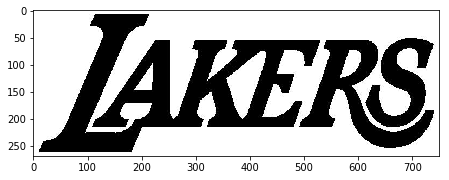

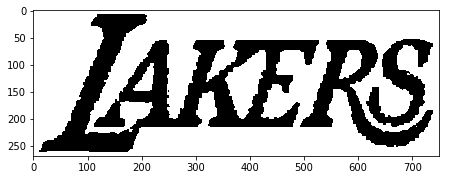

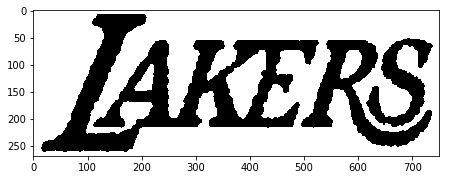

In [10]:
med10 = lambda hidden, observation: extendEnergyFunction2(hidden, observation, 
                                                                  alpha=0, c=0,d=1,e=0,beta=0, gamma=0, 
                                                                  phi=0, sigma=0, eta=0)
med11 = lambda hidden, observation: extendEnergyFunction2(hidden, observation, 
                                                                  alpha=0, c=1,d=0,e=1,beta=1, gamma=0, 
                                                                  phi=0, sigma=0, eta=0)
imrecMed10 = denoise(imnsy, med10)
imrecMed11 = denoise(imnsy, med11)
showimgs(imorg) 
showimgs(imrecMed10) 
showimgs(imrecMed11) 

According to the result, I think the first plate performances well but not good as using $T_{\phi}$ alone.  
And the second plate, the same as $T_{\gamma}$, makes image more smooth, but sharper than $T_{\gamma}$.

According to the whole exercise, I have a deep comprehension of template.  
In this formula:$$\begin{array}{rcl}
E(X,Y) & = & -\alpha \sum\limits_{i} max_{j}(x_iT_{\alpha}^{j}(x_i)) - 
					\sigma \sum\limits_{i} max_{j}(x_iT_{\sigma}^{j}(x_i)) \\
       &   & \quad - \sum\limits_{i} x_i [\beta T_{\beta}(x_i) + \gamma T_{\gamma}(x_i) +
					\phi T_{\phi}(x_i)] - \eta \sum\limits_{i} x_i y_i
\end{array}$$
$T_{\beta}$,$T_{\gamma}$ and $T_{\phi}$ are the filter.  These plate will decide which neighbot points will inclunce $x_i$. So in the plate, choosing the appropriate distance between neighbor points and center point $x_i$.  
I think the distance from 1 to 2 is an appropriate distance.  

And $T_{\alpha}$ and $T_{\sigma}$ will prevent lines and edges. When I increase the weight of using two plates. The lines plate will gets more noise points. But these two plates cannot use together, I do not know why.
  
In conclusion, I think the plates TA given to us performance well.